# Elasticity Modeling Pipeline
This notebook estimates product-level price elasticity using log-log regression and simulates optimal prices based on fitted elasticities. There are a varietal of limitations to this approach and is used as a baseline.



Not super familar with regression for price elasticity, but I think we would use a regression model to predict the price elasticity of demand as this would be the most straightforward way to get the slope and intersect for Revenue calculations.


 We define the own price elasticity of demand as the percentage change in quantity demanded:
E = (dQ/Q) / (dP/P) = (dQ/dP) * (P/Q) 

 If we assume linearlity in logs we can write:
 ln(Q) = a + b * ln(P) + c * ln(P_competitor) + d * X 

From the equations abvove; we should expect that from market behaviour as our price increases our demand should decrease (which is in line with common sense). 

We know from our EDA that is in fact not the case but to meet the given case-study brief we'll calculate the elasticity using this traditional approach

We use a log log regression as a baseline estimate adding in the other features as covariates (sometimes called controls). We can then estimate the optimal price maximising the revenue by doing a grid search over the price space starting at cost price (We don't want to lose money by selling)

We'll both do this at both a category/subcategory level and a product level to evaluate the elasticities and suggest pricing. 







In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from pathlib import Path
from src.utils import constants
from src.eda import eda
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from src.models import demand_forecasting
from src.models import elasticity_model
from src.models import evaluate

## 1. Load Raw Data

In [2]:
PRODUCT_PATH = constants.DATA_RAW_DIR / 'products.csv'
INVENTORY_PATH = constants.DATA_RAW_DIR / 'inventory.csv'
TRANSACTIONS_PATH = constants.DATA_RAW_DIR / 'transactions.csv'
products = pd.read_csv(PRODUCT_PATH , parse_dates=["launch_date"])
transactions = pd.read_csv(TRANSACTIONS_PATH, parse_dates=["timestamp"])
inventory = pd.read_csv(INVENTORY_PATH , parse_dates=["date", "restock_date"])
#Ensure that the date columns are in datetime format
products['launch_date'] = pd.to_datetime(products['launch_date'])
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])
inventory['date'] = pd.to_datetime(inventory['date'])

transactions['promotion_type'] = transactions['promotion_type'].fillna('No Promotion')


## 2. Feature Engineering 

In [3]:

# Create subcategory identifier
products['subcategory'] = (
    products["category_id"].astype(str) + "_" + products["subcategory_id"].astype(str)
)

products_feature_list = ['product_id', 
                         'subcategory', 
                         'supplier_id',
                         'avg_competitor_price', 
                         'quality_score', 
                         'brand_id', 
                         'is_seasonal',
                         'category_id',
                         'subcategory_id',
                         ]


# Clean Promotion Data such that if is_promottion is 0, we can assume that the product is not on promotion i.e when is_promotion = 0, promotion_type = 'No Promotion'
transactions['promotion_type'] = transactions.apply(
    lambda x: 'No Promotion' if x['is_promotion'] == 0 else x['promotion_type'], axis=1
)

# Impute missing values in the quality_score column with the mean of the subcategory
products['quality_score'] = products.groupby('subcategory')['quality_score'].transform(
    lambda x: x.fillna(round(x.mean(), 0))
)

# Impute missing values in the avg_competitor_price column with the mean of the subcategory
products['avg_competitor_price'] = products.groupby('subcategory')['avg_competitor_price'].transform(
    lambda x: x.fillna(x.mean())
)

# Merge dataframes
df = transactions.merge(products[products_feature_list], on='product_id', how='left')
df = df.merge(inventory[['product_id', 'date', 'stock_level']], left_on=['product_id', 'timestamp'], right_on=['product_id', 'date'], how='left')

# Extract week
df['week'] = df['timestamp'].dt.to_period('W').dt.to_timestamp()

# 

df['log_price'] = np.log(df['price'])
df['log_quantity'] = np.log(df['quantity'])
df['log_competitor_price'] = np.log(df['avg_competitor_price'])
df['log_inventory'] = np.log1p(df['stock_level'])





# Aggregate by subcategory-week
agg_by_week_subcat_df = (
    df.groupby(['subcategory', 'week'])
    .agg({
        'price': 'mean',
        'quantity': 'sum',
        'avg_competitor_price': 'mean',
        'quality_score': 'mean',
        'brand_id': lambda x: x.mode().iat[0],
        'supplier_id': lambda x: x.mode().iat[0],
        'is_seasonal': lambda x: x.mode().iat[0],
        'stock_level': 'mean',
        'is_promotion': lambda x: x.mode().iat[0]
    })
    .reset_index()
    .rename(columns={'avg_competitor_price': 'competitor_price'})
)


# Filter for positive quantities
agg_by_week_subcat_df = agg_by_week_subcat_df[agg_by_week_subcat_df['quantity'] > 0].copy()


agg_by_week_subcat_df['log_price'] = np.log(agg_by_week_subcat_df['price'])
agg_by_week_subcat_df['log_quantity'] = np.log(agg_by_week_subcat_df['quantity'])
agg_by_week_subcat_df['log_competitor_price'] = np.log(agg_by_week_subcat_df['competitor_price'])
agg_by_week_subcat_df['log_inventory'] = np.log1p(agg_by_week_subcat_df['stock_level'])


control_columns = ['quality_score', 'brand_id', 'is_promotion', 'is_seasonal', 'supplier_id', 'log_price', 'log_competitor_price', 'log_inventory']



# Repeat aggregation by just week and not subcategory 

agg_by_week_df = (
    df.groupby(['product_id','week'])
    .agg({
        'price': 'mean',
        'quantity': 'sum',
        'avg_competitor_price': 'mean',
        'quality_score': 'mean',
        'brand_id': lambda x: x.mode().iat[0],
        'supplier_id': lambda x: x.mode().iat[0],
        'is_seasonal': lambda x: x.mode().iat[0],
        'stock_level': 'mean',
        'is_promotion': lambda x: x.mode().iat[0]
    })
)

agg_by_week_df = agg_by_week_df[agg_by_week_df['quantity'] > 0].copy()
agg_by_week_df['log_price'] = np.log(agg_by_week_df['price'])
agg_by_week_df['log_quantity'] = np.log(agg_by_week_df['quantity'])
agg_by_week_df['log_competitor_price'] = np.log(agg_by_week_df['avg_competitor_price'])
agg_by_week_df['log_inventory'] = np.log1p(agg_by_week_df['stock_level'])


agg_by_subcat_df = (
    df.groupby(['subcategory', 'timestamp']).agg({  
        'price': 'mean',
        'quantity': 'sum',
        'avg_competitor_price': 'mean',
        'quality_score': 'mean',
        'brand_id': lambda x: x.mode().iat[0],
        'supplier_id': lambda x: x.mode().iat[0],
        'is_seasonal': lambda x: x.mode().iat[0],
        'stock_level': 'mean',
        'is_promotion': lambda x: x.mode().iat[0]
    })
)
agg_by_subcat_df = agg_by_subcat_df[agg_by_subcat_df['quantity'] > 0].copy()
agg_by_subcat_df['log_price'] = np.log(agg_by_subcat_df['price'])     
agg_by_subcat_df['log_quantity'] = np.log(agg_by_subcat_df['quantity'])
agg_by_subcat_df['log_competitor_price'] = np.log(agg_by_subcat_df['avg_competitor_price'])
agg_by_subcat_df['log_inventory'] = np.log1p(agg_by_subcat_df['stock_level'])



# Aggregate by product_id and timestamp (day-level)
agg_by_product_df = (
    df.groupby(['product_id', 'timestamp']).agg({
        'price': 'mean',
        'quantity': 'sum',
        'avg_competitor_price': 'mean',
        'quality_score': 'mean',
        'brand_id': lambda x: x.mode().iat[0],
        'supplier_id': lambda x: x.mode().iat[0],
        'is_seasonal': lambda x: x.mode().iat[0],
        'stock_level': 'mean',
        'is_promotion': lambda x: x.mode().iat[0]
    })
)

# Filter and compute logs
agg_by_product_df = agg_by_product_df[agg_by_product_df['quantity'] > 0].copy()
agg_by_product_df['log_price'] = np.log(agg_by_product_df['price'])
agg_by_product_df['log_quantity'] = np.log(agg_by_product_df['quantity'])
agg_by_product_df['log_competitor_price'] = np.log(agg_by_product_df['avg_competitor_price'])
agg_by_product_df['log_inventory'] = np.log1p(agg_by_product_df['stock_level'])



In [4]:
agg_by_product_df.reset_index(inplace=True)

In [5]:
# Create a train-test split by date for elasticity modeling 
unique_dates = agg_by_product_df['timestamp'].sort_values().unique()
split_point = int(len(unique_dates) * 0.8)
cutoff_date = unique_dates[split_point]

# Split into train and test sets
train_df = agg_by_product_df[agg_by_product_df['timestamp'] <= cutoff_date].copy()
test_df = agg_by_product_df[agg_by_product_df['timestamp'] > cutoff_date].copy()

# Fit model on training data
elasticity_results_train = elasticity_model.fit_log_log_model(
    df=train_df,
    groupby_col='product_id',
    control_cols=control_columns,
    l1_ratio=0.6,
    min_rows=30
)

# Convert to DataFrame and summarize
elasticity_train_df = pd.DataFrame.from_dict(elasticity_results_train, orient='index')
elasticity_train_df = elasticity_train_df.sort_values('beta_price')
elasticity_train_df[['beta_price', 'n_obs', 'best_alpha']]
elasticity_train_df.sort_values('beta_price', ascending=False, inplace=True)

In [6]:
# 

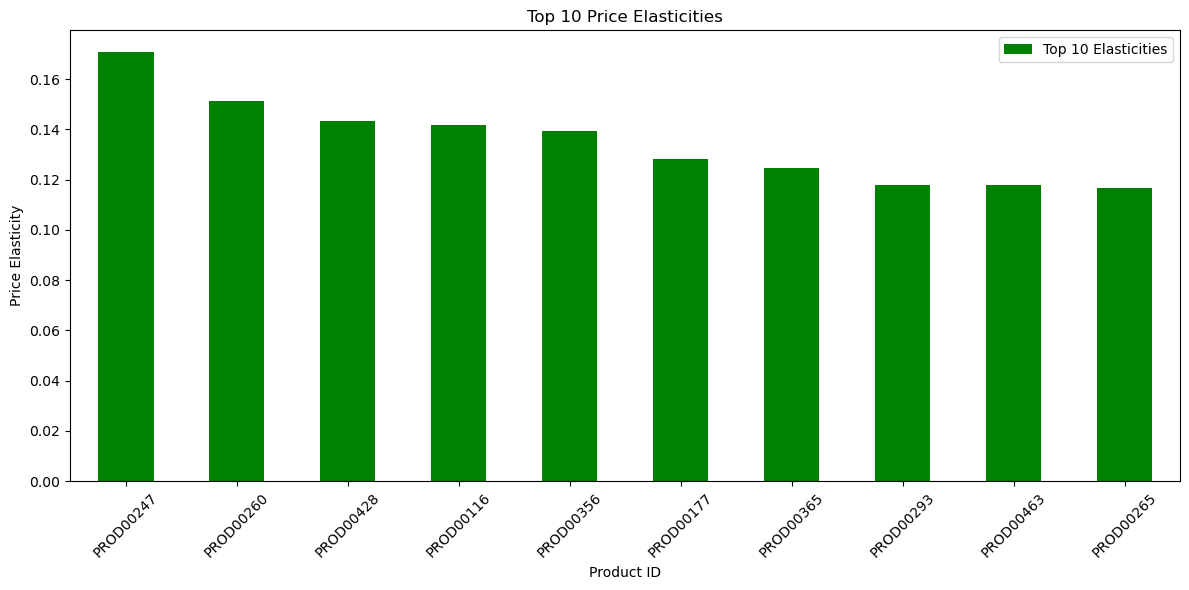

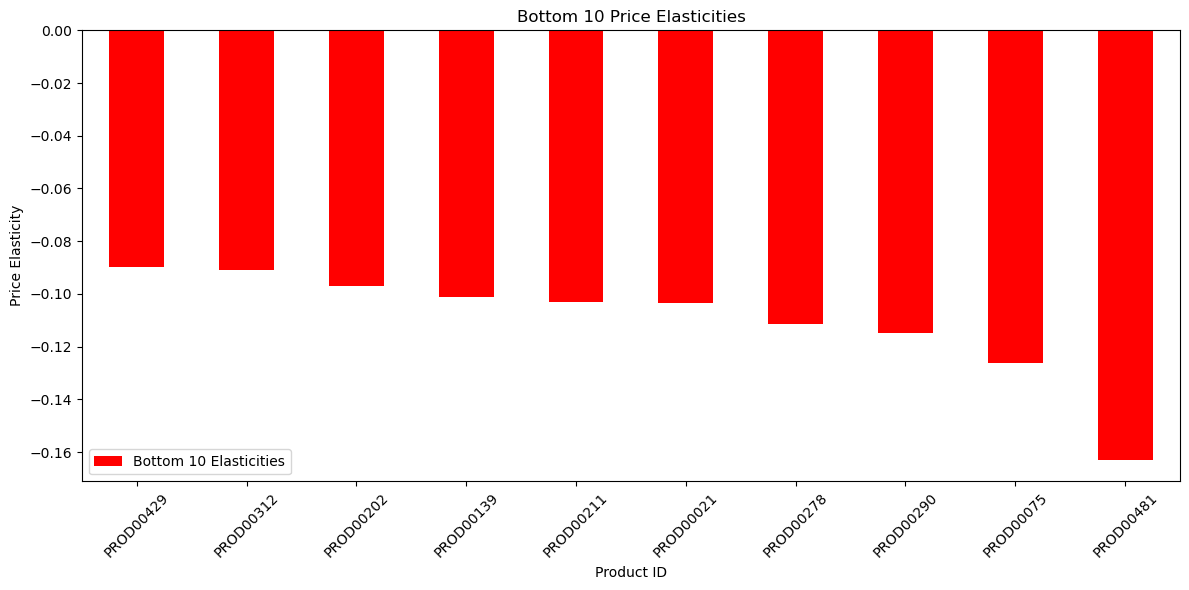

In [7]:
# Get the top 10 and bottom 10 products by elasticity
top_10_elasticity = elasticity_train_df.head(10)    
bottom_10_elasticity = elasticity_train_df.tail(10)

# Plot the top 10 and bottom 10 elasticities
plt.figure(figsize=(12, 6))
top_10_elasticity['beta_price'].plot(kind='bar', color='green', label='Top 10 Elasticities')    

plt.title('Top 10 Price Elasticities')
plt.xlabel('Product ID')
plt.ylabel('Price Elasticity')
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

# Plot bottom 10
plt.figure(figsize=(12, 6))
bottom_10_elasticity['beta_price'].plot(kind='bar', color='red', label='Bottom 10 Elasticities')

plt.title('Bottom 10 Price Elasticities')
plt.xlabel('Product ID')
plt.ylabel('Price Elasticity')
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Lets evaluate our model on the test set

r2_df = evaluate.compute_r_squared_per_product(test_df, elasticity_results_train, control_columns)
r2_df

,product_id,n_obs,R2_log_quantity,beta_price
222,PROD00223,19,0.038484,-0.000000
179,PROD00180,18,0.035910,-0.062420
120,PROD00121,22,0.032783,0.102876
87,PROD00088,17,0.026813,-0.000000
268,PROD00269,23,0.022329,-0.000000
...,...,...,...,...
176,PROD00177,17,-2.292285,0.128309
115,PROD00116,14,-3.042020,0.141631
462,PROD00463,21,-4.985763,0.117839
237,PROD00238,14,-6.667792,0.107765


In [9]:
# Results look less than impressive, -> Maybe we should remove regularization and just use a linear regression model to estimate the elasticity.
# Fit model on training data without regularization
elasticity_results_train_no_reg = elasticity_model.fit_log_log_model(
    df=train_df,
    groupby_col='product_id',
    control_cols=control_columns,
    l1_ratio=0.5, 
    min_rows=10,
    skip_reg= True
)

In [10]:
# Lets evaluate our no regularisation model on the test set

r2_df = evaluate.compute_r_squared_per_product(test_df, elasticity_results_train_no_reg, control_columns)
r2_df

,product_id,n_obs,R2_log_quantity,beta_price
285,PROD00286,17,0.072798,0.060002
288,PROD00289,12,0.056013,-0.051640
233,PROD00234,19,0.039516,0.056527
180,PROD00181,26,0.026526,-0.039476
101,PROD00102,12,0.014374,-0.053004
...,...,...,...,...
167,PROD00168,23,-6.552134,0.222576
462,PROD00463,21,-8.174275,0.162046
115,PROD00116,14,-8.592928,0.253696
289,PROD00290,13,-9.384341,-0.169051


In [11]:
# As expdected, the results are much better with regards to R2 (By definition), but we have not improved the model much; Given that we want to use this model for price elasticity, 
# we should be careful about overfitting (as there is also a lot of noise in the data).

In [12]:



cost_price_lookup = products.set_index('product_id')['base_cost']


base_controls_by_product = (
    train_df.groupby('product_id').agg({
        'is_promotion': lambda x: x.mode().iat[0] if not x.mode().empty else 0,
        'log_inventory': 'mean',
        'log_competitor_price': 'mean',
        'quality_score': 'mean',
        'brand_id': lambda x: x.mode().iat[0] if not x.mode().empty else -1,
        'supplier_id': lambda x: x.mode().iat[0] if not x.mode().empty else -1,
        'is_seasonal': lambda x: x.mode().iat[0] if not x.mode().empty else 0
    })
)


# Redo simulations using product-specific price ranges
all_simulations = []

for product_id, elasticity in elasticity_results_train.items():
    if product_id not in base_controls_by_product.index or product_id not in cost_price_lookup.index:
        continue

    controls = base_controls_by_product.loc[product_id].to_dict()
    cost_price = cost_price_lookup.loc[product_id]

    # Create price grid starting from cost price
    price_grid = np.linspace(cost_price, cost_price * 3, 5)

    sim_df = elasticity_model.simulate_demand_curve(
        elasticity=elasticity,
        price_grid=price_grid,
        base_controls=controls
    )
    sim_df['product_id'] = product_id
    all_simulations.append(sim_df)


# Concatenate all simulations
all_simulations_df = pd.concat(all_simulations, ignore_index=True)

# Identify optimal price per product (max revenue)
optimal_prices_df = (
    all_simulations_df.loc[all_simulations_df.groupby('product_id')['expected_revenue'].idxmax()]
    .sort_values(by='expected_revenue', ascending=False)
)



In [13]:
all_simulations_df

,price,expected_demand,expected_revenue,product_id
0,54.850,2.663033,146.067381,PROD00001
1,82.275,2.663033,219.101071,PROD00001
2,109.700,2.663033,292.134762,PROD00001
3,137.125,2.663033,365.168452,PROD00001
4,164.550,2.663033,438.202143,PROD00001
...,...,...,...,...
2495,198.440,2.714884,538.741672,PROD00500
2496,297.660,2.714884,808.112508,PROD00500
2497,396.880,2.714884,1077.483344,PROD00500
2498,496.100,2.714884,1346.854179,PROD00500


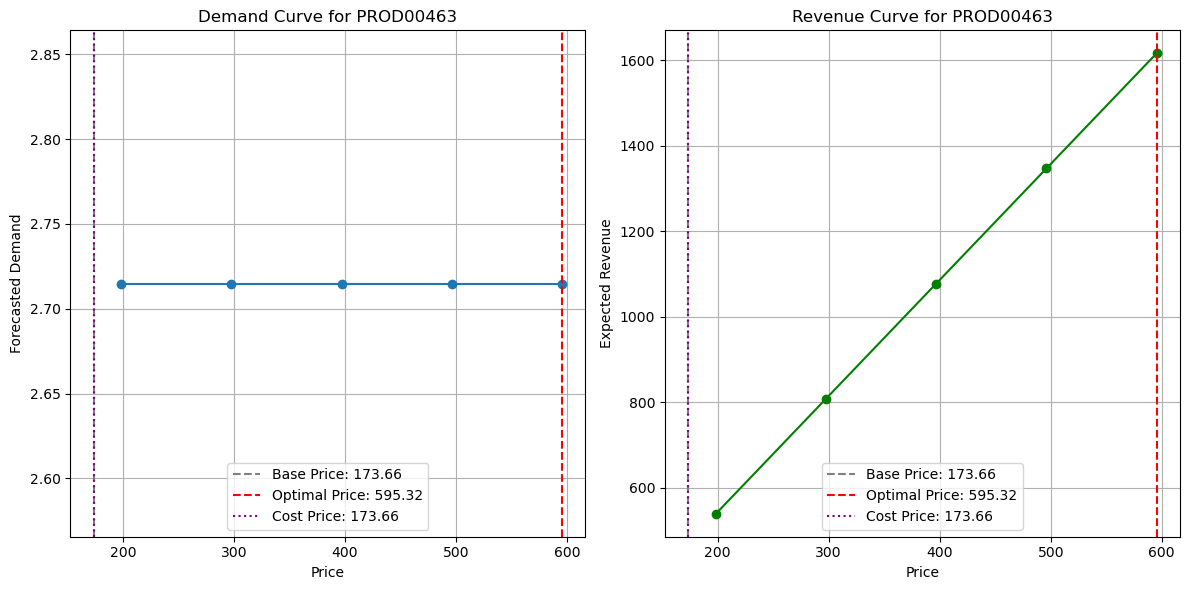

In [26]:
pid = 'PROD00463'
cost_price = cost_price_lookup.loc[pid]

elasticity_model.plot_demand_curve(
   sim_df=sim_df,
   product_id=pid,
   base_price=cost_price ,
   cost_price= cost_price
)

In [25]:
optimal_prices_df.head(10)

,price,expected_demand,expected_revenue,product_id
2314,520.98,9.050568,4715.165004,PROD00463
1189,335.43,11.602441,3891.806872,PROD00238
884,410.49,7.746707,3179.945732,PROD00177
1824,586.26,4.744422,2781.464613,PROD00365
659,562.62,4.457752,2508.020164,PROD00132
189,572.52,4.378430,2506.738527,PROD00038
1829,486.87,4.957550,2413.682132,PROD00366
579,257.34,8.459253,2176.904096,PROD00116
1554,580.53,3.690276,2142.316190,PROD00311
2054,575.22,3.665554,2108.500007,PROD00411


# Discussion

Many products are non-elastic in the dataset; with values > = -0.1. 
This suggest that we can raise prices without a signficant demand impact; and is the case where we have the optimal price being the highest value in our defined gridsearch for Revenue.

From our EDA we knew that this was due to
- Non Linear Price- Demand Relationships
- Intermittent demand patterns

which may have resulted from the synthetic data of the case study. To improve this we can generate a non-linear price demand forecasting to address the intermittent demand and see if we can get anything meaningful, we can also probally looking at lags to see if we can make this elasiticity model a bit more performant and smooth out noise. 